# In this notebook we are going to predict the price of Bulldozer using Machine learning.

* These are the steps that we are going to follow
  1. Problem Defination
  2. Data
  3. Evaluation
  4. Features
  5. Experimentation

## 1. Problem Defination
> How can we predict the future selling price of a Bulldozer, given its characterstics and previous examples of how much similar bulldozers has been sold for

## 2. Data
### The data is downloaded form the kaggle Bule Book for Bulldozers competation

#### There are three main Datasets in the link
* https://www.kaggle.com/c/bluebook-for-bulldozers/data
* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation
## The Evaluation is mentioned in the competation
> The evaluation metric foe this competation is the RMSLE(Root Mean Squared Log Error) between actual and predicted auction prices

For more visit the link https://www.kaggle.com/c/bluebook-for-bulldozers/overview

## 4. Features
> You can visit above links for more info about the features

In [41]:
# Imports

#import tools required for EDA or Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import  model
from sklearn.ensemble import RandomForestRegressor

# import evaluation and tuning models
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [2]:
# lets import the training and validation sets

df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",low_memory=False)

In [3]:
len(df)

412698

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

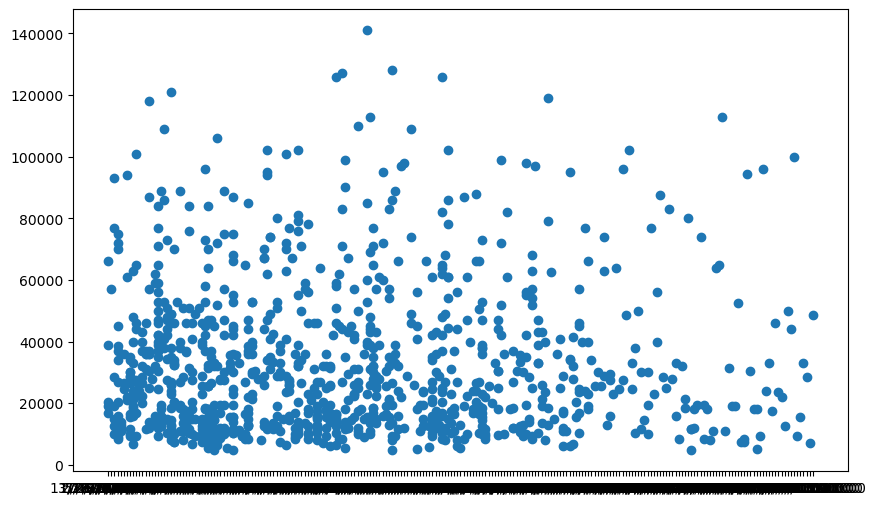

In [5]:
fig,ax = plt.subplots(figsize=(10,6))
plt.scatter(df.saledate[:1000],df.SalePrice[:1000])

<Axes: ylabel='Frequency'>

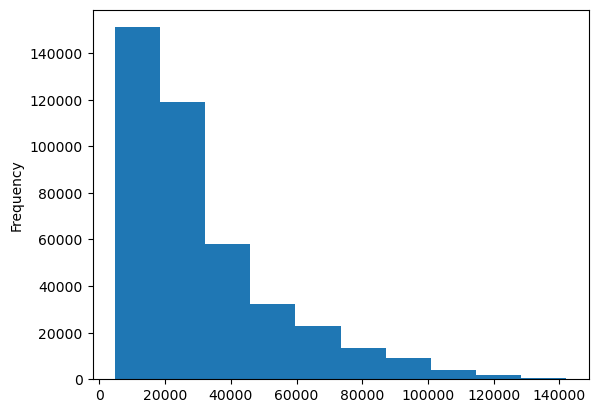

In [6]:
df.SalePrice.plot(kind="hist")

###  Parsing dates

When working with time series data we want to enrich the time and date components as much as possible

we can do that by telling pandas which or our columns has dates in it by using `Parse Dates` parameter

In [7]:
# import the data again but this time with parse date
df = pd.read_csv("bluebook-for-bulldozers/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [8]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

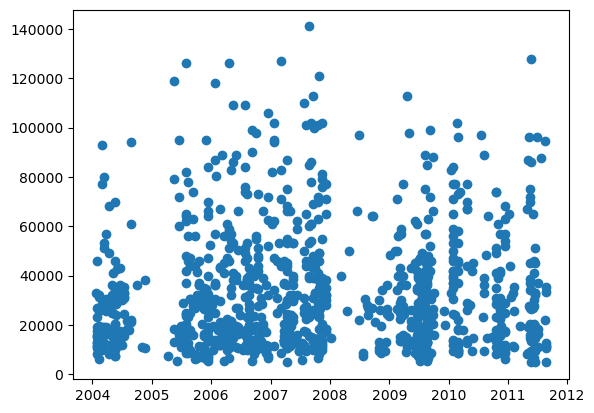

In [9]:
plt.scatter(df.saledate[:1000],df.SalePrice[:1000])

In [10]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## lets bring some order to our dataframe so 
### sorting dataframe by sales date

In [11]:
df = df.sort_values(by=["saledate"])

In [12]:
df.saledate[:100]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
            ...    
113454   1989-01-31
62665    1989-01-31
78445    1989-01-31
233279   1989-02-01
28223    1989-02-01
Name: saledate, Length: 100, dtype: datetime64[ns]

# we have made some changes to our dataframe so now make a working copy of our dataframe so if we go wrong we can revert

In [13]:
df_tmp = df.copy()
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [14]:
# lets enrich the data with salefdate
df_tmp["SaleYear"] = df_tmp.saledate.dt.year
df_tmp["SaleMonth"] = df_tmp.saledate.dt.month
df_tmp["SaleDate"] = df_tmp.saledate.dt.day
df_tmp["SaleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["SaleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [15]:
# since we have enriched the data with date and time features we can remove the sale date form the dataframe
df_tmp = df_tmp.drop("saledate",axis=1)

In [16]:
df_tmp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'SaleYear', 'SaleMonth',
       'SaleDate', 'SaleDayOfWeek', 'SaleDayOfYear'],
      dtyp

In [17]:
df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Iowa               1336
Montana            1336
Oklahoma           1326
Nebraska            866
West Virgi

# modeling

In [18]:
# lets build a machine learning model 
model = RandomForestRegressor(n_jobs=-1,random_state=42)
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

# so we got this error because there are some missing values as well as not all the data is in numerical format

In [19]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [20]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

# Here we have got both misisng values and object/ string we we need to fix them first


## Lets convert the objects into pandas category



In [21]:
# 1. find the columns that has object
for labels,contents in df_tmp.items():
    if pd.api.types.is_object_dtype(contents):
        print(labels)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [22]:
# 2. convert them into  pandas Catogory
for labels,contents in df_tmp.items():
    if pd.api.types.is_object_dtype(contents):
        df_tmp[labels] = contents.astype("category").cat.as_ordered()

In [23]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

## Now lets deal with missing values

In [24]:
# lets deal with missing numerical values
# 1. find the mising numeric values
for labels,contents in df_tmp.items():
    if pd.api.types.is_numeric_dtype(contents):
        if pd.isnull(contents).sum():
            print(labels)


auctioneerID
MachineHoursCurrentMeter


In [25]:
# 2. Fill the missing numeric values
for label,contents in df_tmp.items():
    if pd.api.types.is_numeric_dtype(contents):
        if pd.isnull(contents).sum():
            # add a binary column to see if data was missing
            df_tmp[label+"_was_missing"] = pd.isnull(contents)
            # fill the missing values with median
            df_tmp[label] =  contents.fillna(contents.median())

In [26]:
# lets check
for labels,contents in df_tmp.items():
    if pd.api.types.is_numeric_dtype(contents):
        if pd.isnull(contents).sum():
            print(labels)

## Fill non numeric missing values

In [27]:
# 1. find those columns
for labels,contents in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(contents):
        if pd.isnull(contents).sum():
            print(labels)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
# lets turn these catogories into numnbers and fill them
for labels,contents in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(contents):
        # add  a binary column to see if the value was missing
        df_tmp[labels+"_was_missing"] = pd.isnull(contents)

        # Turn into number ad fill missing
        df_tmp[labels] = pd.Categorical(contents).codes+1

In [29]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
                                ..
Backhoe_Mounting_was_missing     0
Blade_Type_was_missing           0
Travel_Controls_was_missing      0
Differential_Type_was_missing    0
Steering_Controls_was_missing    0
Length: 103, dtype: int64

# now we have filled all the missing values as well as converted strings into categories
 now we can build a mahine learning model

In [30]:
%%time

# instinciate the model
model = RandomForestRegressor(n_jobs=-1,random_state=42)

# lets fit the model
model.fit(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

CPU times: total: 32min 24s
Wall time: 9min 5s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [31]:
model.score(df_tmp.drop("SalePrice",axis=1),df_tmp["SalePrice"])

0.9875468079970562

# This result is not reliable as it same data is used for training and testing

In [32]:
# now lets split the data into training and validation split
df_val = df_tmp[df_tmp["SaleYear"] == 2012]
df_train = df_tmp[df_tmp["SaleYear"] != 2012]

In [33]:
# split the data into x and y
x_train,y_train = df_train.drop("SalePrice",axis=1),df_train["SalePrice"]
x_valid,y_valid = df_val.drop("SalePrice",axis=1),df_val["SalePrice"]

In [34]:
x_train.shape,y_train.shape,x_valid.shape,y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

# Build our own Evaluation function


In [35]:
# create a function (The cpmtetation uses root mean squared log error)
from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score

def rmsle(y_test,y_preds):
    """ Calculate root mean square log error between actual and predicted values """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))


# create a function to evaluate few different models
def show_scores(model):
    train_preds = model.predict(x_train)
    valid_preds = model.predict(x_valid)

    scores = {"Train MAE":mean_absolute_error(y_train,train_preds),
             "valid MAE":mean_absolute_error(y_valid,valid_preds),
             "Train RMSLE":rmsle(y_train,train_preds),
             "Valid RMSLE":rmsle(y_valid,valid_preds),
             "Train R^2":r2_score(y_train,train_preds),
             "valid R^2":r2_score(y_valid,valid_preds)}
    return scores

In [36]:
# instinciating the model by cutting down the samples
model = RandomForestRegressor(n_jobs=-1,random_state=42,max_samples=10000)

In [37]:
%%time
model.fit(x_train,y_train)


CPU times: total: 1min 11s
Wall time: 30.4 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [38]:
show_scores(model)

{'Train MAE': 5561.2988092240585,
 'valid MAE': 7177.26365505919,
 'Train RMSLE': np.float64(0.257745378256977),
 'Valid RMSLE': np.float64(0.29362638671089003),
 'Train R^2': 0.8606658995199189,
 'valid R^2': 0.8320374995090507}

# Hyper parameter Tuning using Random search cv

In [42]:
%%time

rf_grid = {"n_estimators":np.arange(10,100,10),
          "max_depth":[None,3,5,10],
          "min_samples_split":np.arange(2,20,2),
          "min_samples_leaf":np.arange(1,20,2),
          "max_features":["sqrt","log2"],
          "max_samples":[10000]}

#lets instinciate the Randomize search for random forest classifier
rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1,random_state=42),param_distributions=rf_grid,n_iter=5,verbose=True)

# fit the model
rs_model.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 2min 7s
Wall time: 51.1 s


RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [43]:
rs_model.best_params_

{'n_estimators': np.int64(90),
 'min_samples_split': np.int64(14),
 'min_samples_leaf': np.int64(1),
 'max_samples': 10000,
 'max_features': 'log2',
 'max_depth': None}

In [44]:
show_scores(rs_model)

{'Train MAE': 7903.482456927757,
 'valid MAE': 9717.062668565648,
 'Train RMSLE': np.float64(0.34948672452718277),
 'Valid RMSLE': np.float64(0.3933740414799776),
 'Train R^2': 0.7419999186687466,
 'valid R^2': 0.7270034789055895}

In [45]:
rs_model.score(x_valid,y_valid)

0.7270034789055895

In [50]:
%%time
# now lets train a model with best hyperparameters
# most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,min_samples_split=14,min_samples_leaf=1,max_samples=10000,max_features="log2",max_depth=None,n_jobs=-1,random_state=42)

# fit the ideal model
ideal_model.fit(x_train,y_train)

CPU times: total: 6.58 s
Wall time: 2.14 s


RandomForestRegressor(max_features='log2', max_samples=10000,
                      min_samples_split=14, n_estimators=90, n_jobs=-1,
                      random_state=42)

In [51]:
show_scores(ideal_model)

{'Train MAE': 7903.482456927757,
 'valid MAE': 9717.062668565648,
 'Train RMSLE': np.float64(0.34948672452718277),
 'Valid RMSLE': np.float64(0.3933740414799776),
 'Train R^2': 0.7419999186687466,
 'valid R^2': 0.7270034789055895}

In [52]:
ideal_score=ideal_model.score(x_valid,y_valid)

In [61]:
model_score = model.score(x_valid,y_valid)

In [77]:
ideal_score,model_score

(0.7270034789055895, 0.8320374995090507)

# Now lets make the predictions on test data

In [108]:
# import test data
test_df = pd.read_csv("bluebook-for-bulldozers/Test.csv",low_memory=False,parse_dates=["saledate"])

In [109]:
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [110]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

# lets preprocess the data and get them into same format

In [111]:
# 1. enrich the test data with date and time features
test_df["SaleYear"] = test_df.saledate.dt.year
test_df["SaleMonth"] = test_df.saledate.dt.month
test_df["SaleDate"] = test_df.saledate.dt.day
test_df["SaleDayOfWeek"] = test_df.saledate.dt.dayofweek
test_df["SaleDayOfYear"] = test_df.saledate.dt.dayofyear

#now drop the saledate column
test_df = test_df.drop("saledate",axis=1)

In [112]:
# fill the mssing numeric column with median
for labels,contents in test_df.items():
    if pd.api.types.is_numeric_dtype(contents):
        if pd.isnull(contents).sum():
            # add a binary column to see if value was missing or not
            test_df[labels+"_was_missing"] = pd.isnull(contents)

            # fill the numeric values with median
            test_df[labels] = contents.fillna(contents.median())

In [113]:
# convert string into cat and fill the missing
for labels,contents in test_df.items():
    if not pd.api.types.is_numeric_dtype(contents):
        # add a binary column
        test_df[labels+"_was_missing"] = pd.isnull(contents)
        # convert into num and fill missing
        test_df[labels] = pd.Categorical(contents).codes + 1
        

In [114]:
test_df.isna().sum()

SalesID                          0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                     0
                                ..
Backhoe_Mounting_was_missing     0
Blade_Type_was_missing           0
Travel_Controls_was_missing      0
Differential_Type_was_missing    0
Steering_Controls_was_missing    0
Length: 101, dtype: int64

In [115]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 101 entries, SalesID to Steering_Controls_was_missing
dtypes: bool(45), float64(1), int16(2), int32(5), int64(6), int8(42)
memory usage: 2.0 MB


In [116]:
x_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_was_missing', 'Stick_Length_was_missing',
       'Thumb_was_missing', 'Pattern_Changer_was_missing',
       'Grouser_Type_was_missing', 'Backhoe_Mounting_was_missing',
       'Blade_Type_was_missing', 'Travel_Controls_was_missing',
       'Differential_Type_was_missing', 'Steering_Controls_was_missing'],
      dtype='object', length=102)

In [117]:
test_df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width_was_missing', 'Stick_Length_was_missing',
       'Thumb_was_missing', 'Pattern_Changer_was_missing',
       'Grouser_Type_was_missing', 'Backhoe_Mounting_was_missing',
       'Blade_Type_was_missing', 'Travel_Controls_was_missing',
       'Differential_Type_was_missing', 'Steering_Controls_was_missing'],
      dtype='object', length=101)

In [119]:
set(x_train.columns) - set(test_df.columns)

{'auctioneerID_was_missing'}

In [120]:
test_df["auctioneerID_was_missing"] = False

In [122]:
ideal_preds = ideal_model.predict(test_df[x_train.columns])

In [123]:
ideal_preds

array([20168.35651231, 23700.12006512, 46083.21824533, ...,
       23852.0794545 , 29107.65656411, 30861.89153285], shape=(12457,))

In [124]:
# lets format the data
df_preds = pd.DataFrame()
df_preds["SalesID"] = test_df["SalesID"]
df_preds["SalesPrice"] = ideal_preds

df_preds

,SalesID,SalesPrice
0,1227829,20168.356512
1,1227844,23700.120065
2,1227847,46083.218245
3,1227848,46615.040281
4,1227863,33938.181046
...,...,...
12452,6643171,28486.622157
12453,6643173,29751.490138
12454,6643184,23852.079454
12455,6643186,29107.656564
